In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import os
import time
import copy

In [26]:
DATA_PATH = 'data' 
BATCH_SIZE = 32
IMG_SIZE = 224 
EPOCHS = 10 

In [3]:
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [4]:
full_dataset = datasets.ImageFolder(root=DATA_PATH, transform=data_transform)

In [5]:
full_dataset.class_to_idx

{'drive': 0, 'legglance-flick': 1, 'pullshot': 2, 'sweep': 3}

In [6]:
total_size = len(full_dataset)
train_size = int(0.8 * total_size)   # 80%
val_size = int(0.1 * total_size)     # 10%
test_size = total_size - train_size - val_size # 10%

In [7]:
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)


print(f"Total image : {total_size} | Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Total image : 4724 | Train: 3779 | Val: 472 | Test: 473


In [8]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

torch.Size([32, 3, 224, 224])


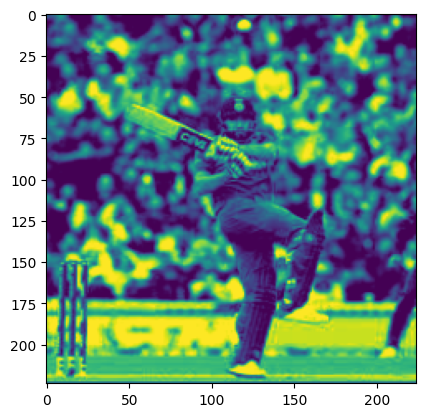

In [19]:
images, labels = next(iter(train_loader))
print(images.shape)
plt.imshow(images[0][0])

# Using ResNet18 pretrain model and training on that

In [21]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/aksha/cricket-pose/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aksha/cricket-pose/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/aksha/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


In [24]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    print(f"Training on device: {device}")

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
                dataloader = train_loader
            else:
                model.eval() 
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS)

torch.save(trained_model.state_dict(), 'cricket_shot_classifier.pth')
print("Model saved to cricket_shot_classifier.pth")

Training on device: cuda
Epoch 1/10
Train Loss: 1.0404 Acc: 0.5832
Val Loss: 0.8215 Acc: 0.6907
Epoch 2/10
Train Loss: 0.7148 Acc: 0.7597
Val Loss: 0.6545 Acc: 0.7436
Epoch 3/10
Train Loss: 0.6041 Acc: 0.7947
Val Loss: 0.5705 Acc: 0.8051
Epoch 4/10
Train Loss: 0.5346 Acc: 0.8240
Val Loss: 0.5013 Acc: 0.8369
Epoch 5/10
Train Loss: 0.4848 Acc: 0.8386
Val Loss: 0.4550 Acc: 0.8411
Epoch 6/10
Train Loss: 0.4559 Acc: 0.8550
Val Loss: 0.4535 Acc: 0.8347
Epoch 7/10
Train Loss: 0.4178 Acc: 0.8653
Val Loss: 0.4103 Acc: 0.8538
Epoch 8/10
Train Loss: 0.3956 Acc: 0.8748
Val Loss: 0.3993 Acc: 0.8623
Epoch 9/10
Train Loss: 0.3754 Acc: 0.8801
Val Loss: 0.3978 Acc: 0.8581
Epoch 10/10
Train Loss: 0.3722 Acc: 0.8762
Val Loss: 0.3637 Acc: 0.8665
Training complete in 3m 21s
Best Val Acc: 0.8665
Model saved to cricket_shot_classifier.pth


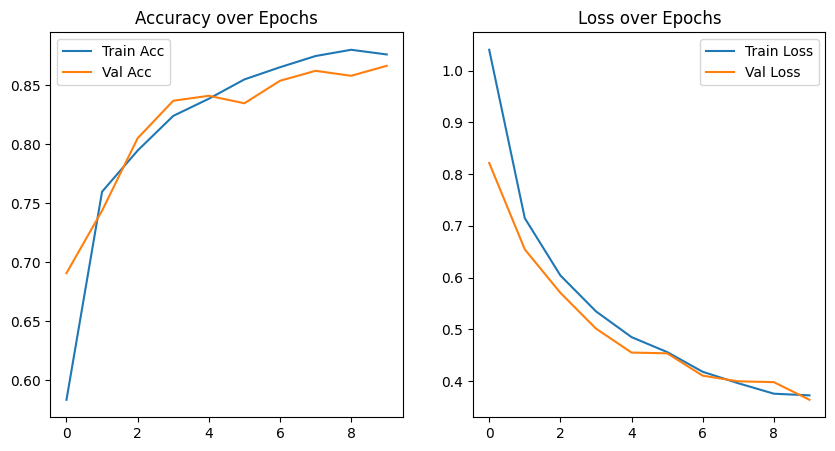

In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

Since the dataset is small so running at high Epochs cause the model to overfit so to avoid we are using lower epochs with a learning rate of 0.001 on a pretrained model for a quick and stable model 